# XGBoost

Grid size: 648 parameter combinations
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}

Training final model with optimized parameters...

MODEL PERFORMANCE
----------------------------
TEST SET METRICS:
R^2 Score: 0.8955
RMSE: 40.4670
MAE: 26.0279

TRAINING SET METRICS:
R^2 Score: 0.9418
RMSE: 31.9054
MAE: 19.2043


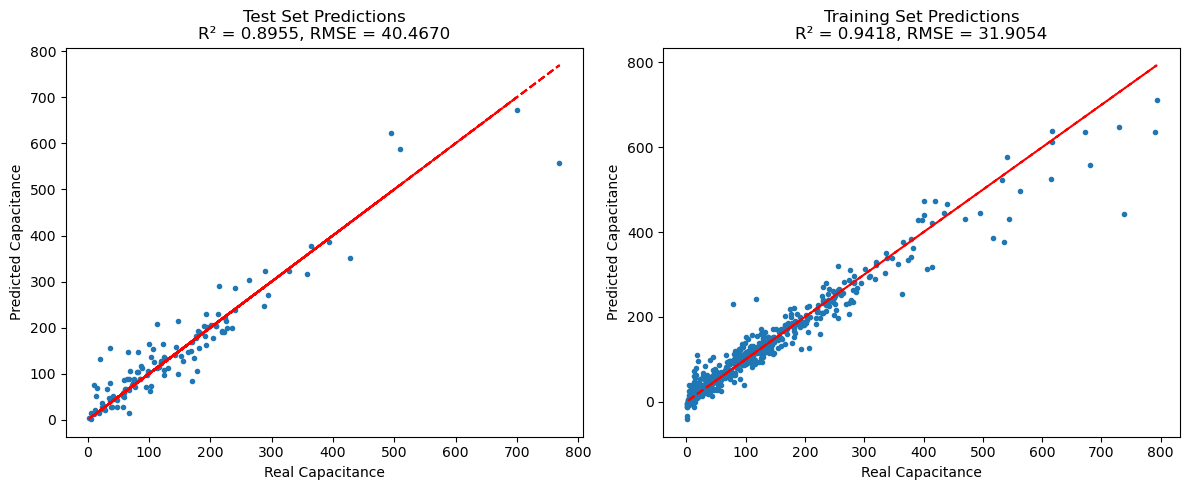

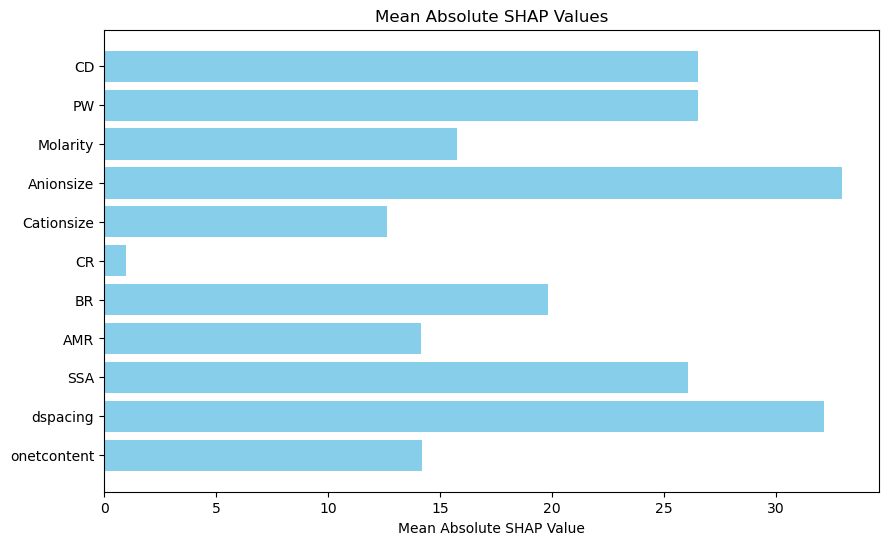

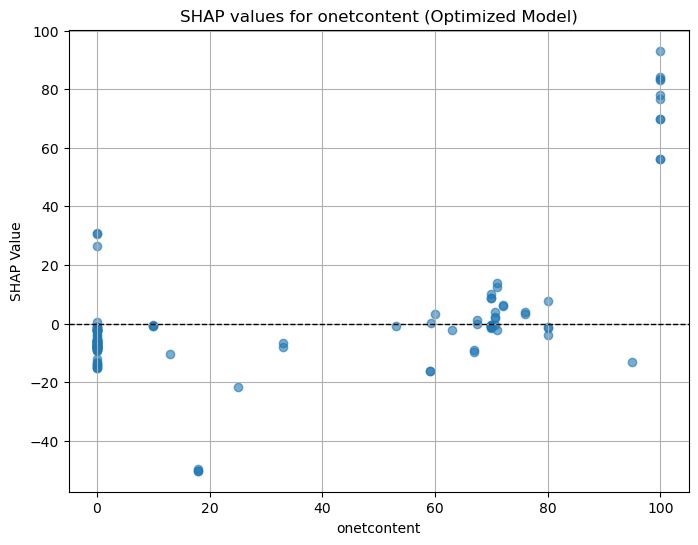

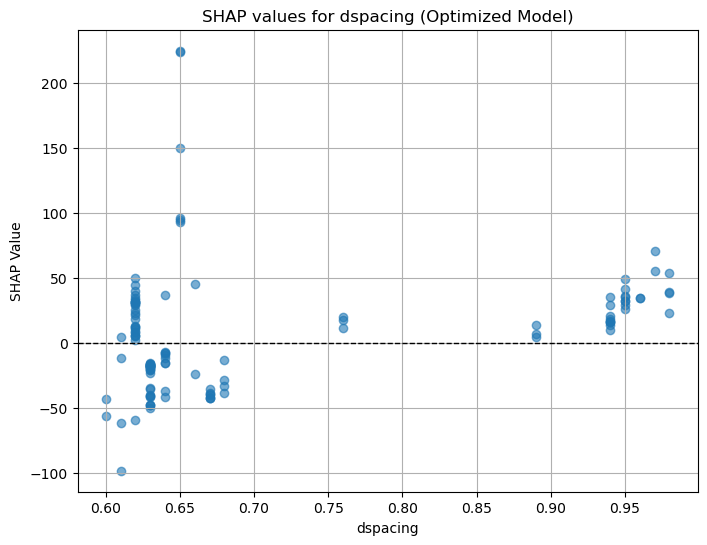

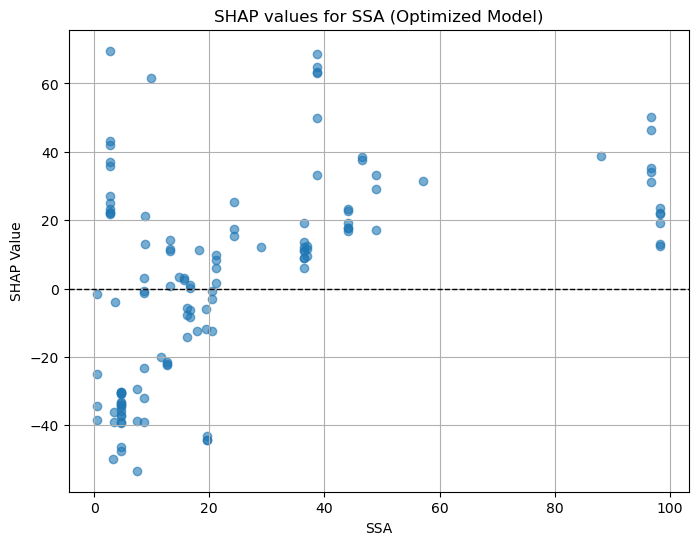

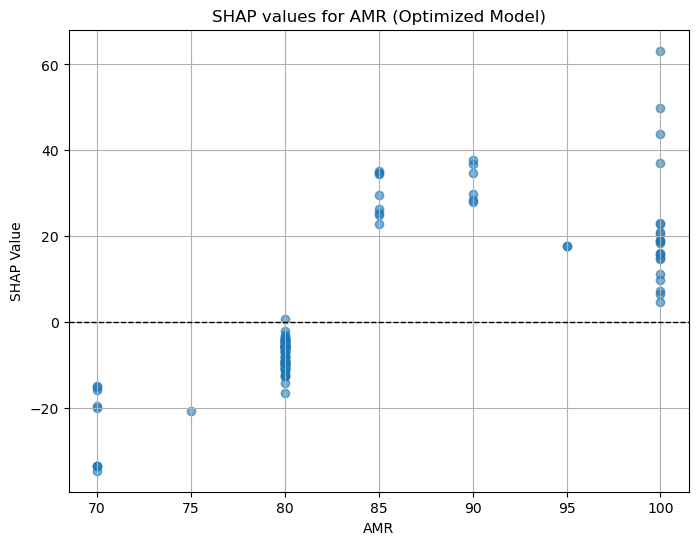

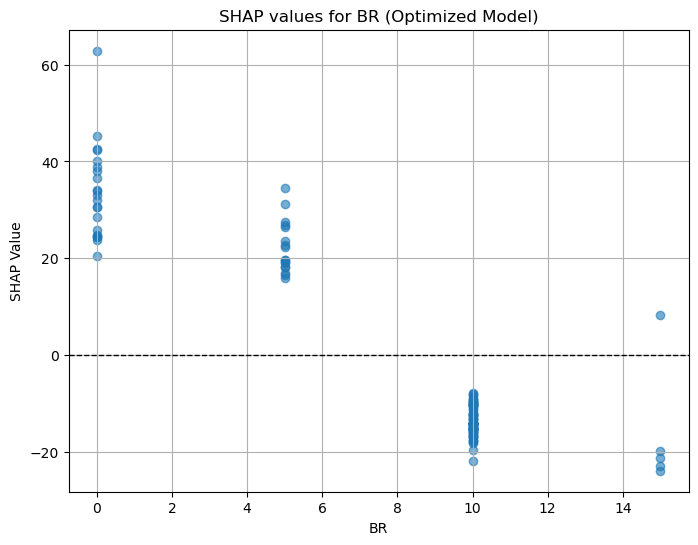

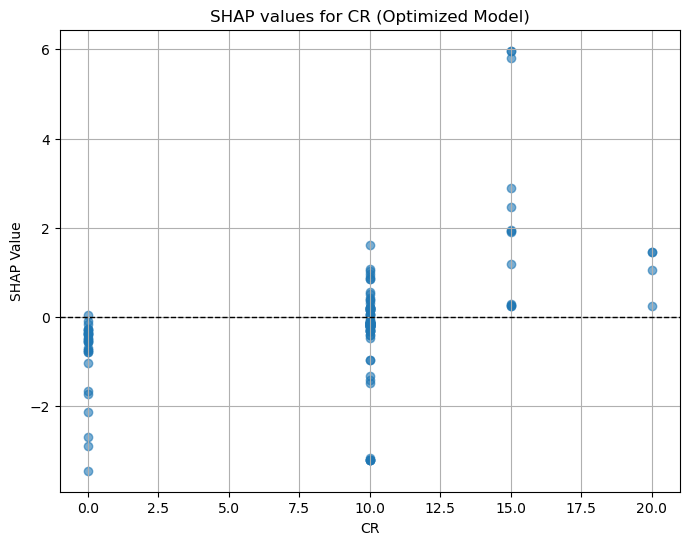

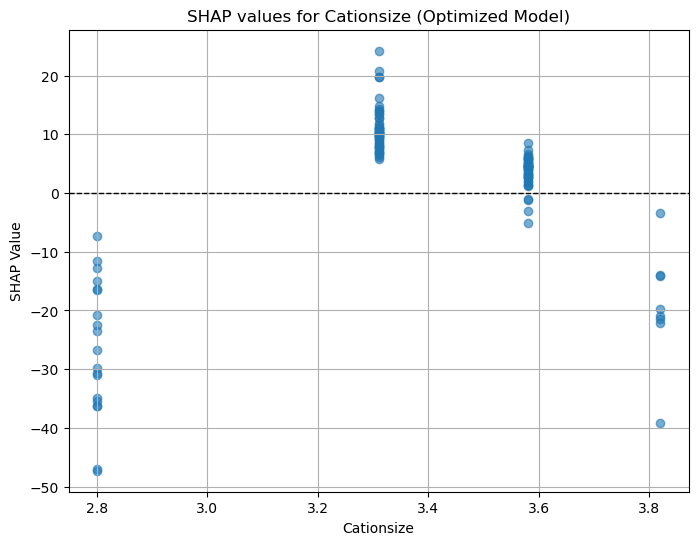

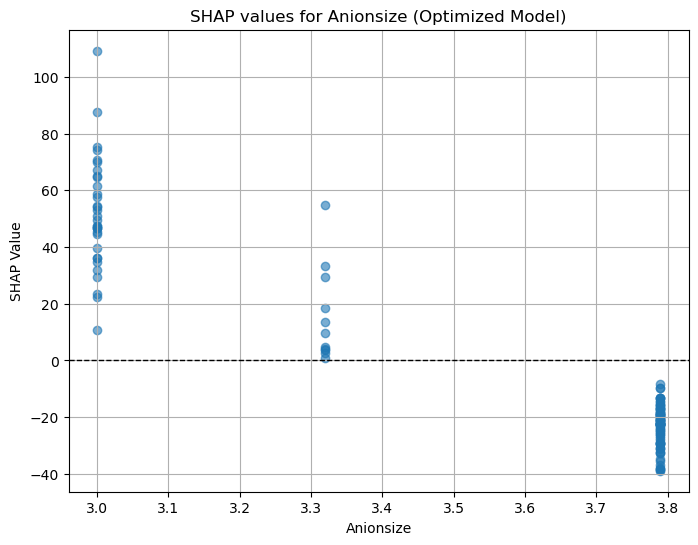

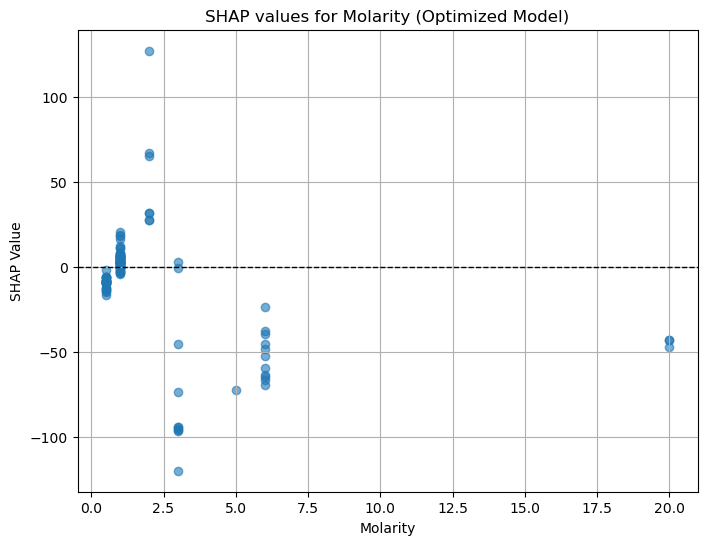

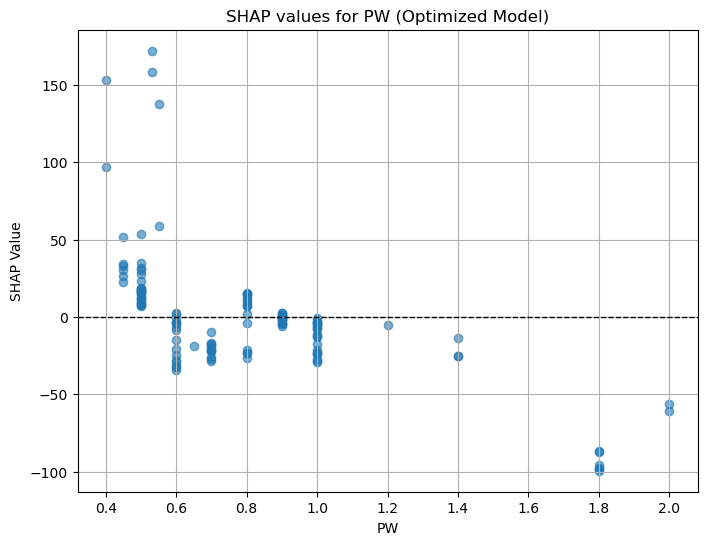

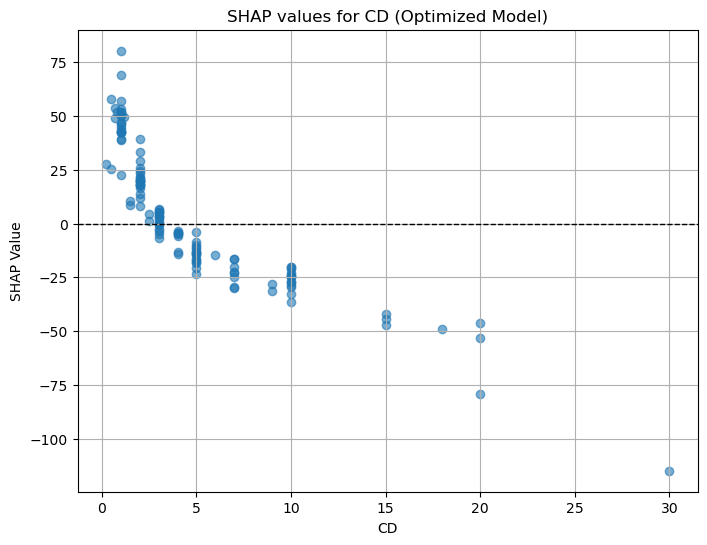

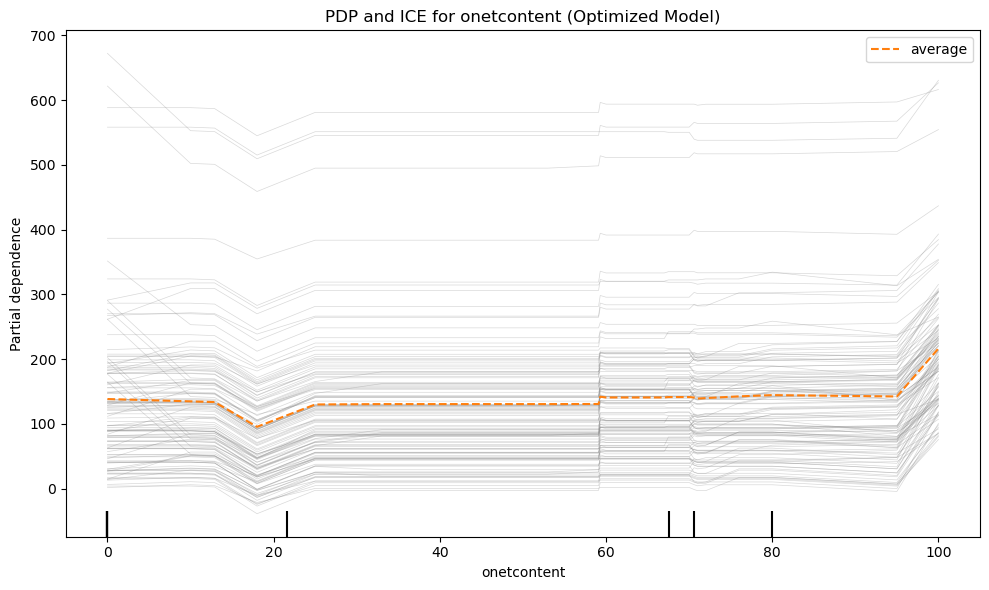

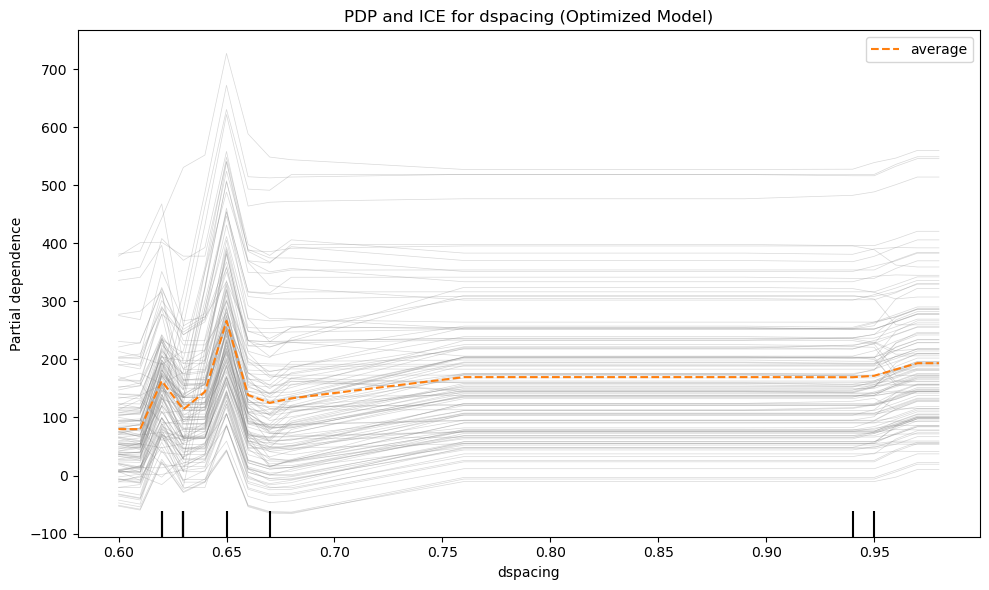

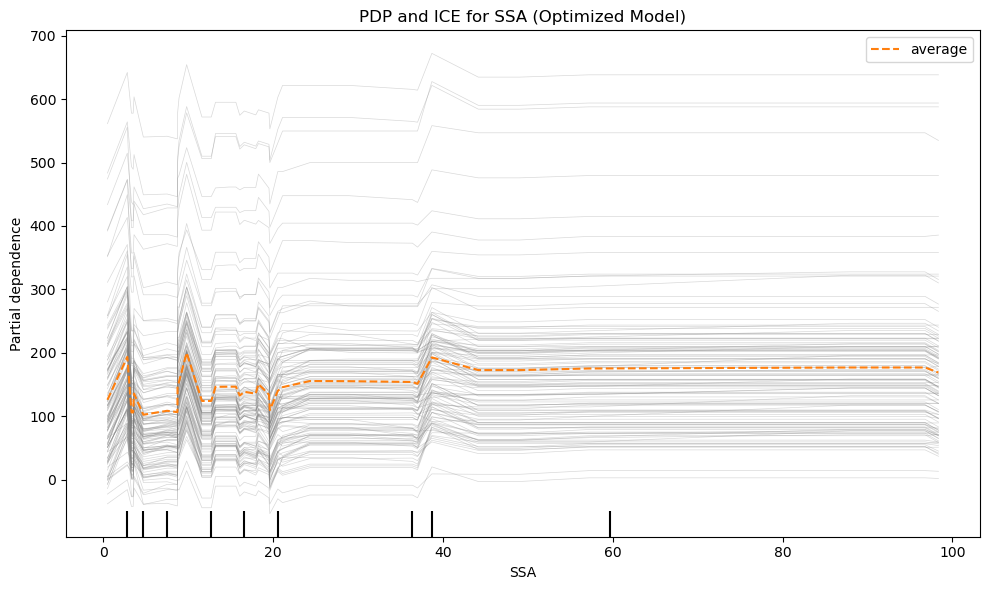

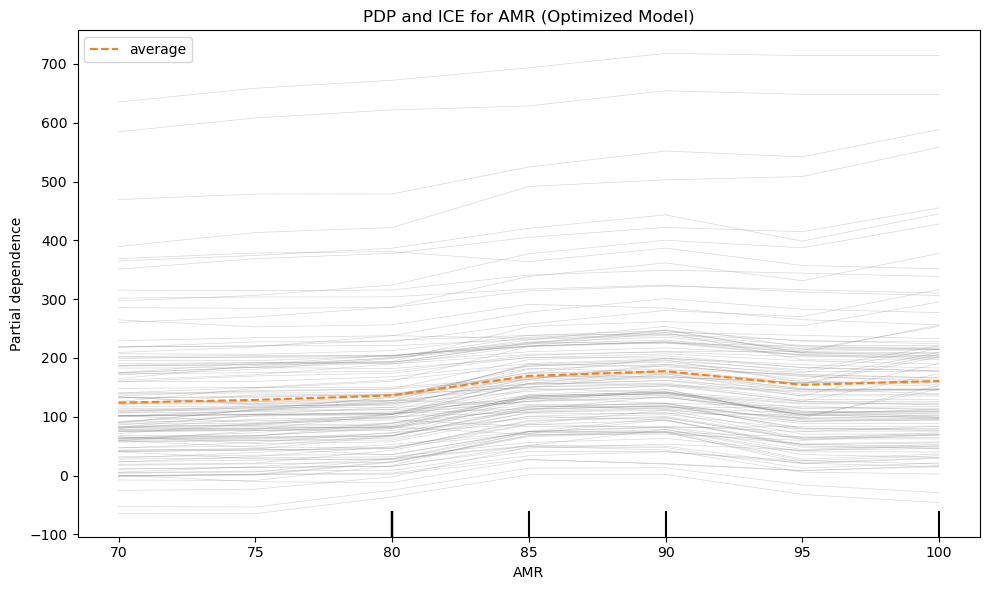

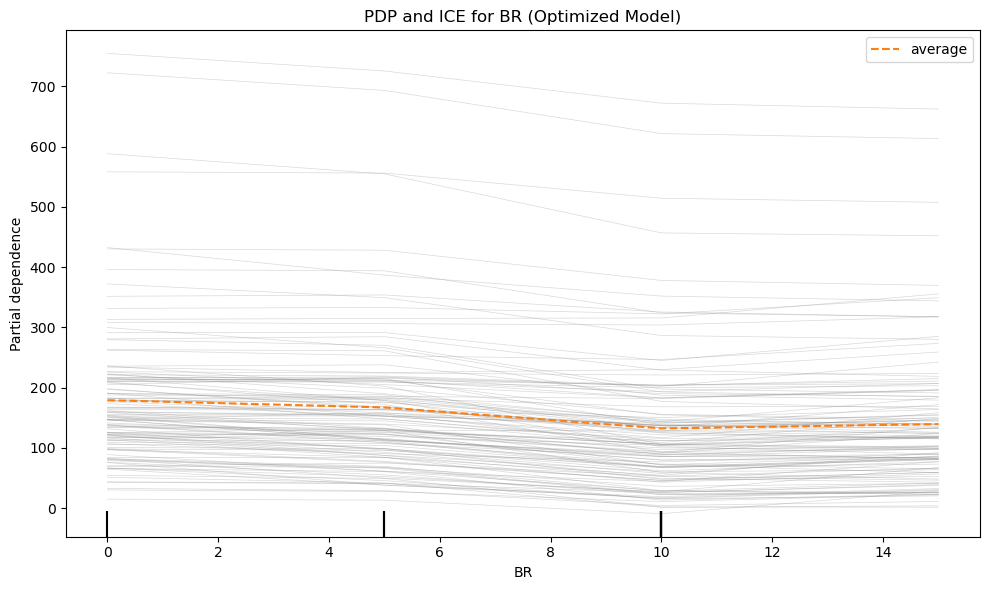

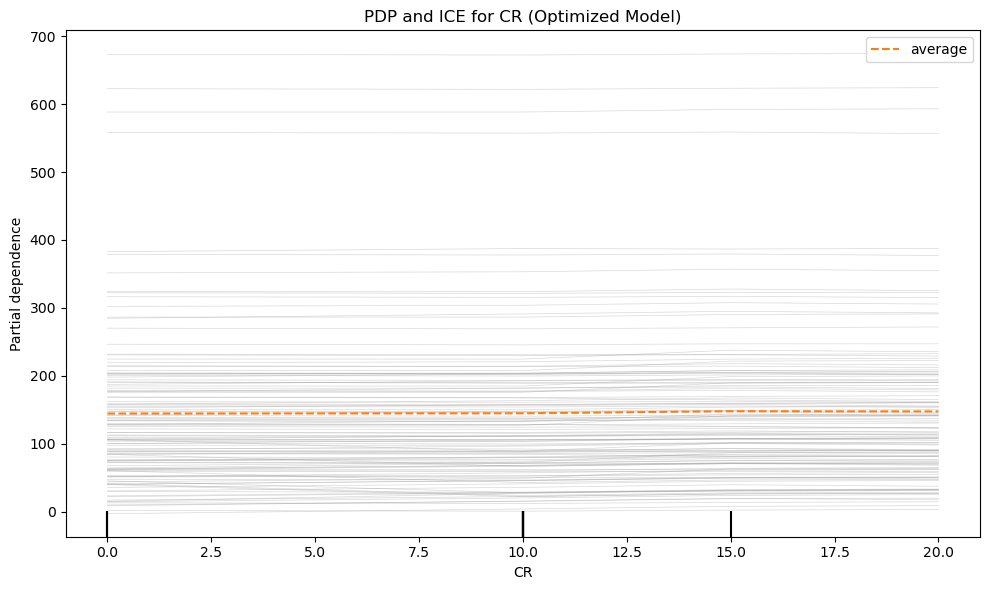

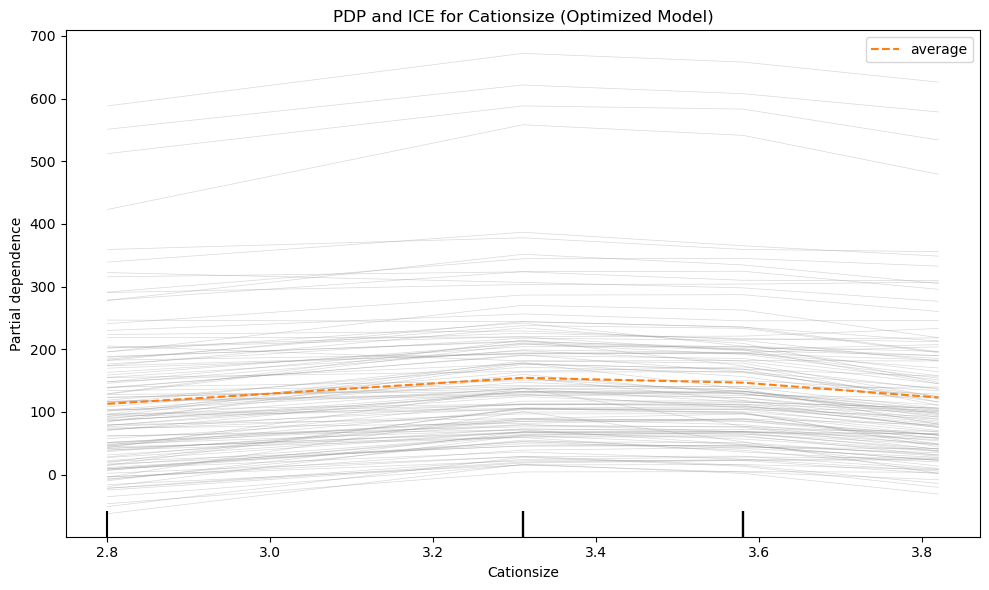

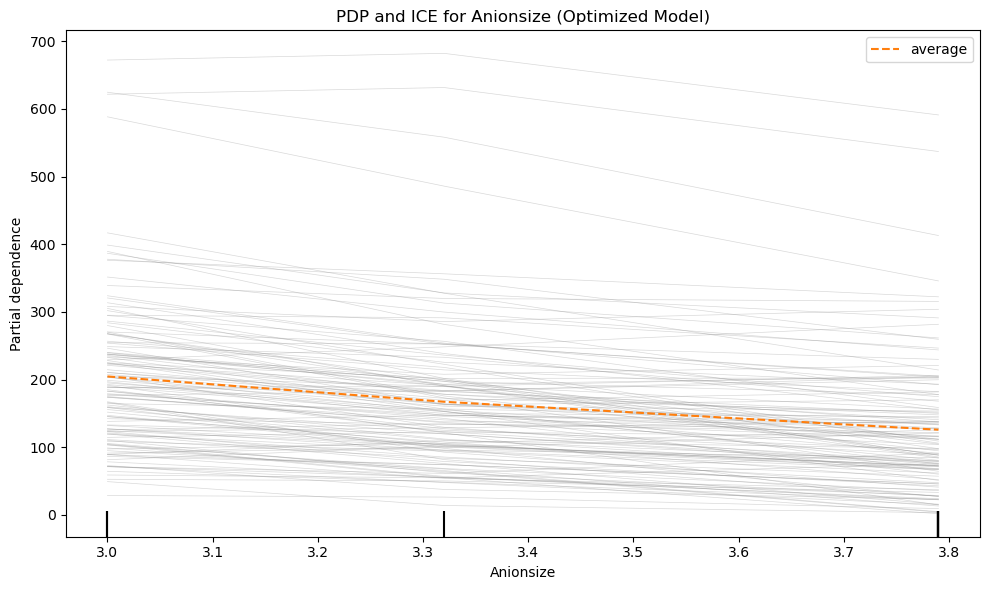

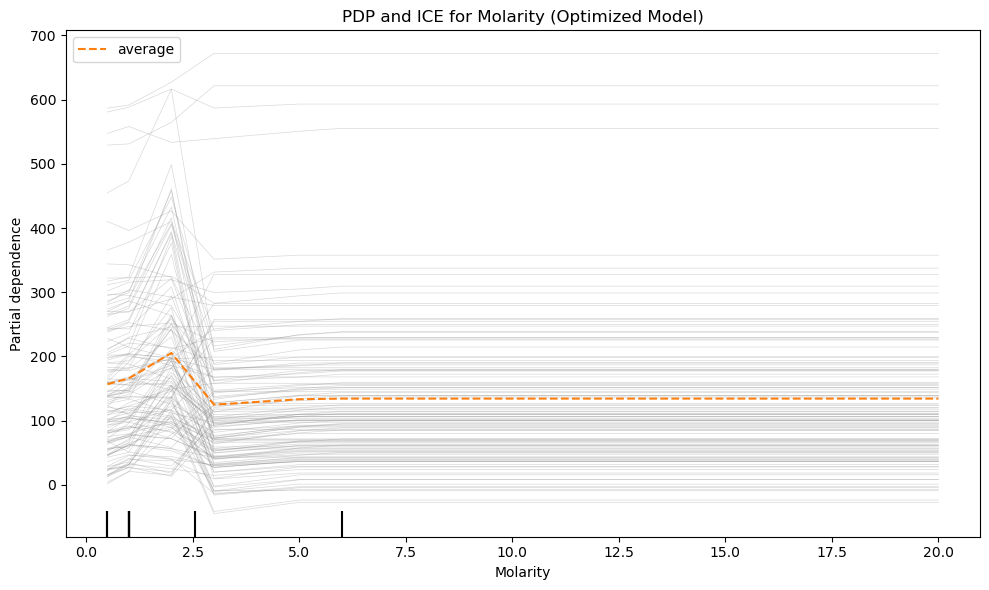

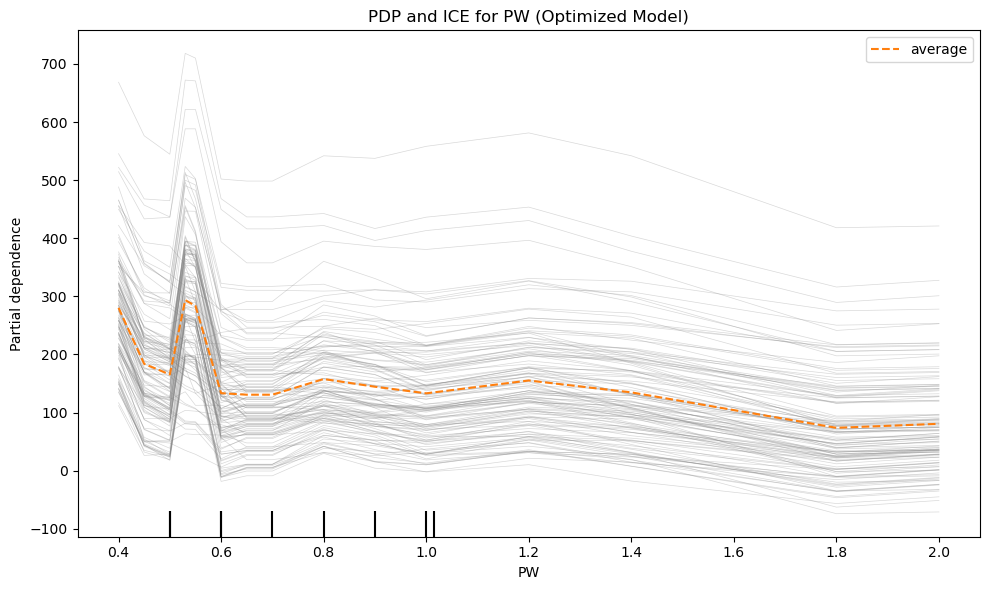

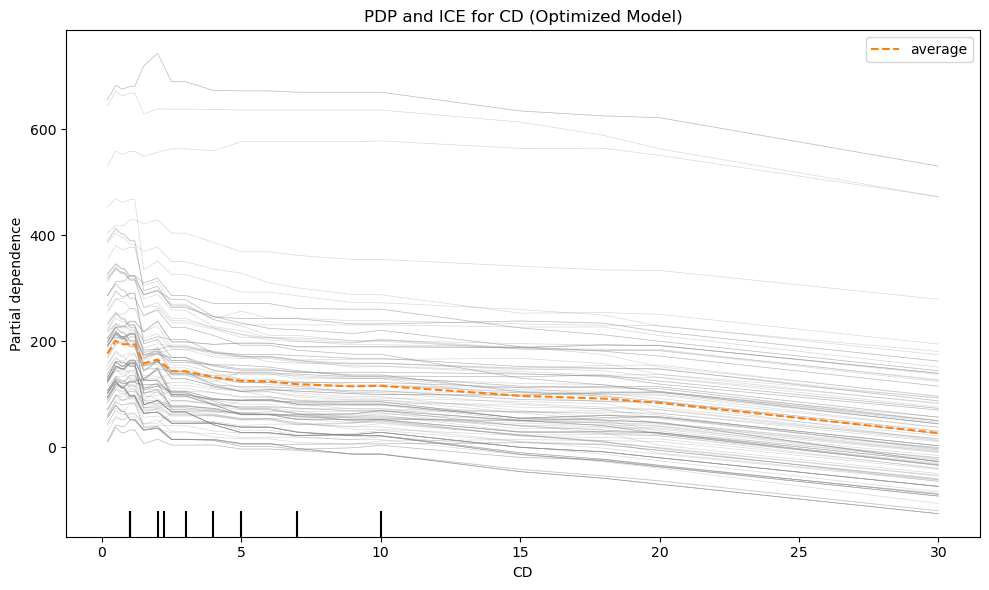

Generating 2D PDP for features: onetcontent and dspacing
2D PDP data saved to 2DPDPXGB_onetcontent_dspacing.xlsx
Generating 2D PDP for features: onetcontent and SSA
2D PDP data saved to 2DPDPXGB_onetcontent_SSA.xlsx
Generating 2D PDP for features: onetcontent and AMR
2D PDP data saved to 2DPDPXGB_onetcontent_AMR.xlsx
Generating 2D PDP for features: onetcontent and BR
2D PDP data saved to 2DPDPXGB_onetcontent_BR.xlsx
Generating 2D PDP for features: onetcontent and CR
2D PDP data saved to 2DPDPXGB_onetcontent_CR.xlsx
Generating 2D PDP for features: onetcontent and Cationsize
2D PDP data saved to 2DPDPXGB_onetcontent_Cationsize.xlsx
Generating 2D PDP for features: onetcontent and Anionsize
2D PDP data saved to 2DPDPXGB_onetcontent_Anionsize.xlsx
Generating 2D PDP for features: onetcontent and Molarity
2D PDP data saved to 2DPDPXGB_onetcontent_Molarity.xlsx
Generating 2D PDP for features: onetcontent and PW
2D PDP data saved to 2DPDPXGB_onetcontent_PW.xlsx
Generating 2D PDP for features: o

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import xgboost as xgb
import pickle
import shap

DatasetI= pd.read_excel ('DatasetI3-PMM.xlsx')

numerical_features = ['onetcontent', 'dspacing', 'SSA', 'AMR', 'BR', 'CR', 'Cationsize', 'Anionsize', 'Molarity', 'PW', 'CD']
categorical_features = ['Config']

x = DatasetI[numerical_features + categorical_features]
y = DatasetI['Capacitance']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=100)

class TrackingXGB(xgb.XGBRegressor):
    def fit(self, X, y, **kwargs):
        self.X_train_ = X
        self.y_train_ = y
        return super().fit(X, y, **kwargs)
 
def scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    test_r2 = metrics.r2_score(y, y_pred)
    
    y_train_pred = estimator.predict(estimator.X_train_)
    train_r2 = metrics.r2_score(estimator.y_train_, y_train_pred)
    
    overfitting_score = abs(train_r2 - test_r2)
    
    alpha = 3 
    objective = test_r2 - alpha * overfitting_score
    
    return objective

# Parameter grid 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.2], 
    'colsample_bytree': [0.7, 0.9],  
    'subsample': [0.8, 1.0]  
}

print(f"Grid size: {np.prod([len(v) for v in param_grid.values()])} parameter combinations")

# Create GridSearchCV 
grid_search = GridSearchCV(
    TrackingXGB(random_state=42, early_stopping_rounds=5, eval_metric='rmse'),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train, eval_set=[(x_train, y_train)], verbose=False)

# Get best parameters
best_params = grid_search.best_params_

print("Best parameters:", best_params)

print("\nTraining final model with optimized parameters...")
optimized_model = xgb.XGBRegressor(**best_params, 
                                  random_state=42,
                                  early_stopping_rounds=5,
                                  eval_metric='rmse')

optimized_model.fit(x_train, y_train, eval_set=[(x_train, y_train)], verbose=False)

# Cross Validation (10-fold)
cv_model = xgb.XGBRegressor(**best_params, random_state=42)
cv_scores = cross_val_score(cv_model, x, y, cv=10)

# Prediction for test set
y_pred = optimized_model.predict(x_test)

# Evaluation metrics for test set
mae_XGB = metrics.mean_absolute_error(y_test, y_pred)
mse_XGB = metrics.mean_squared_error(y_test, y_pred)
rmse_XGB = np.sqrt(mse_XGB)  
r2_XGB = metrics.r2_score(y_test, y_pred)

# Prediction for training set
y_pred_train = optimized_model.predict(x_train)

# Evaluation metrics for training set
mae_XGB_train = metrics.mean_absolute_error(y_train, y_pred_train)
mse_XGB_train = metrics.mean_squared_error(y_train, y_pred_train)
rmse_XGB_train = np.sqrt(mse_XGB_train)  
r2_XGB_train = metrics.r2_score(y_train, y_pred_train)

r2_diff = abs(r2_XGB_train - r2_XGB)
rmse_diff = abs(rmse_XGB_train - rmse_XGB)

# Print
print("\nMODEL PERFORMANCE")
print("----------------------------")
print("TEST SET METRICS:")
print(f"R^2 Score: {r2_XGB:.4f}")
print(f"RMSE: {rmse_XGB:.4f}")
print(f"MAE: {mae_XGB:.4f}")
print("\nTRAINING SET METRICS:")
print(f"R^2 Score: {r2_XGB_train:.4f}")
print(f"RMSE: {rmse_XGB_train:.4f}")
print(f"MAE: {mae_XGB_train:.4f}")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test, y_pred, '.')
plt.plot(y_test, y_test, color='red', linestyle='--')
plt.xlabel('Real Capacitance')
plt.ylabel('Predicted Capacitance')
plt.title(f'Test Set Predictions\nR² = {r2_XGB:.4f}, RMSE = {rmse_XGB:.4f}')

plt.subplot(1, 2, 2)
plt.plot(y_train, y_pred_train, '.')
plt.plot(y_train, y_train, color='red', linestyle='--')
plt.xlabel('Real Capacitance')
plt.ylabel('Predicted Capacitance')
plt.title(f'Training Set Predictions\nR² = {r2_XGB_train:.4f}, RMSE = {rmse_XGB_train:.4f}')

plt.tight_layout()
plt.savefig('XGB predictions.png', dpi=300)
plt.show()

# Create DataFrames for both test and training results
test_results_df = pd.DataFrame({
    'Real Capacitance': y_test,
    'Predicted Capacitance': y_pred
})

train_results_df = pd.DataFrame({
    'Real Capacitance': y_train,
    'Predicted Capacitance': y_pred_train
})

# Save results
with pd.ExcelWriter('XGB Results.xlsx') as writer:
    test_results_df.to_excel(writer, sheet_name='Test_Results', index=False)
    train_results_df.to_excel(writer, sheet_name='Train_Results', index=False)
    pd.DataFrame([best_params]).to_excel(writer, sheet_name='Optimized_Parameters', index=False)
    
    # Add comparison metrics
    metrics_df = pd.DataFrame({
        'Metric': ['R^2 Test', 'R^2 Train', 'R^2 Difference', 'RMSE Test', 'RMSE Train', 'RMSE Difference', 
                   'MAE Test', 'MAE Train'],
        'Value': [r2_XGB, r2_XGB_train, r2_diff, rmse_XGB, rmse_XGB_train, rmse_diff, 
                  mae_XGB, mae_XGB_train]
    })
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)

# Save model
with open('XGB_model.pkl', 'wb') as f:
    pickle.dump(optimized_model, f)
#------------------------------------------------------------------------------------------------------------------------------------------
# Mean Absolute SHAP Value
#------------------------------------------------------------------------------------------------------------------------------------------
explainer = shap.Explainer(optimized_model, x_train)
shap_values = explainer(x)

shap_values_array = shap_values.values
numerical_shap_values = shap_values_array[:, :len(numerical_features)]

mean_abs_shap_values = np.abs(numerical_shap_values).mean(axis=0)

mean_abs_shap_df = pd.DataFrame({
    'Feature': numerical_features,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})

plt.figure(figsize=(10, 6))
plt.barh(mean_abs_shap_df['Feature'], mean_abs_shap_df['Mean Absolute SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values')
plt.show()

mean_abs_shap_df.to_excel('Mean_Absolute_SHAP_Values.xlsx', index=False)
#-----------------------------------------------------------------
# SHAP ANALYSIS
#-----------------------------------------------------------------
explainer = shap.TreeExplainer(optimized_model)

shap_values = explainer.shap_values(x_test)

shap_data = {}

for num_feature in numerical_features:
    feature_idx = list(x_test.columns).index(num_feature)
    
    shap_data[num_feature] = pd.DataFrame({
        'Feature': num_feature,
        'SHAP Value': shap_values[:, feature_idx],  
        'Feature Value': x_test[num_feature].values 
    })

    plt.figure(figsize=(8, 6))
    plt.scatter(shap_data[num_feature]['Feature Value'], shap_data[num_feature]['SHAP Value'], alpha=0.6)
    plt.title(f'SHAP values for {num_feature} (Optimized Model)')
    plt.xlabel(num_feature)
    plt.ylabel('SHAP Value')
    plt.grid(True)
    plt.axhline(0, color='black', lw=1, ls='--')  # Add a horizontal line at 0 for reference
    plt.show()  


with pd.ExcelWriter('XGB_SHAP.xlsx') as writer:
    for num_feature in shap_data:
        shap_data[num_feature].to_excel(writer, sheet_name=f'{num_feature}_SHAP', index=False)

#-----------------------------------------------------------------
# PDP-ICE
#-----------------------------------------------------------------

features_for_pdp = ['onetcontent', 'dspacing', 'SSA', 'AMR', 'BR', 'CR', 'Cationsize', 'Anionsize', 'Molarity', 'PW', 'CD']
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
for feature in features_for_pdp:
    try:
        pdp_result = partial_dependence(optimized_model, x_test, [feature], kind='both')

        pdp_values = pdp_result['average'][0]  # PDP values
        pdp_grid = pdp_result['grid_values'][0]  # Feature values for PDP

        ice_values = pdp_result['individual'][0] 

        pdp_df = pd.DataFrame({
            f'{feature}': pdp_grid,
            'PDP': pdp_values
        })

        ice_df = pd.DataFrame(ice_values, columns=pdp_grid)
        ice_df.insert(0, 'Instance', range(1, ice_df.shape[0] + 1))

        with pd.ExcelWriter(f'XGBPDPICE-{feature}.xlsx') as writer:
            pdp_df.to_excel(writer, sheet_name='PDP', index=False)
            ice_df.to_excel(writer, sheet_name='ICE', index=False)

        fig, ax = plt.subplots(figsize=(10, 6))
        PartialDependenceDisplay.from_estimator(
            optimized_model,
            X=x_test,
            features=[feature],
            kind='both',
            ax=ax,
            ice_lines_kw={"color": "gray", "alpha": 0.3}
        )
        ax.set_title(f"PDP and ICE for {feature} (Optimized Model)")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"PDP/ICE plot failed for {feature}: {e}")
#---------------------------------------------------------------------------------------
#2D PDP
#---------------------------------------------------------------------------------------
from itertools import combinations
from sklearn.inspection import partial_dependence

feature_pairs = list(combinations(numerical_features, 2))  

for feature1, feature2 in feature_pairs:
    print(f"Generating 2D PDP for features: {feature1} and {feature2}")
    
    pdp_result = partial_dependence(
        optimized_model, 
        x_test, 
        features=[feature1, feature2],
        grid_resolution=20  
    )
    
    pdp_grid1 = pdp_result['grid_values'][0]  
    pdp_grid2 = pdp_result['grid_values'][1]  
    pdp_values = pdp_result['average'] 
    
    grid1, grid2 = np.meshgrid(pdp_grid1, pdp_grid2)
    
    pdp_df = pd.DataFrame({
        f'{feature1}': pdp_grid1.repeat(len(pdp_grid2)),
        f'{feature2}': np.tile(pdp_grid2, len(pdp_grid1)),
        'PDP': pdp_values.flatten()
    })

    file_name = f'2DPDPXGB_{feature1}_{feature2}.xlsx'
    pdp_df.to_excel(file_name, index=False)
    print(f"2D PDP data saved to {file_name}")